In [1]:
#1. Loading and Eploring data

import pandas as pd
df = pd.read_csv('creditcard.csv')
df.info()
df['Class'].value_counts()

print(df["Class"].value_counts(normalize=True))  # Check imbalance


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [2]:
#2. Preprocessing 
    #Scale 'Amount' (since it's not PCA-transformed)
    #Drop 'Time' (optional, often not useful)
    

from sklearn.preprocessing import StandardScaler

df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df.drop(columns=['Time'], inplace=True)

In [6]:
#3. Handle Class Imbalance
#Use SMOTE (Synthetic Minority Oversampling Technique)

from imblearn.over_sampling import SMOTE

X = df.drop('Class', axis=1)
y = df['Class']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
df = df.drop_duplicates()

In [11]:
#4. Anomaly Detection (unsupervised)
    #Apply Isolation Forest and Local Outlier Factor.

X_clean = X.drop_duplicates()


from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

iso = IsolationForest(contamination=0.0017, random_state=42)
lof = LocalOutlierFactor(n_neighbors=50)

y_pred_lof = lof.fit_predict(X_clean)
y_pred_lof = (y_pred_lof == -1).astype(int)
y_pred_iso = iso.fit_predict(X)
y_pred_iso = (y_pred_iso == -1).astype(int)


In [12]:
#5. Train XGBoost Classifier (supervised)
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res)
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [13]:
#6. Evaluating with proper metrics
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_probs)
auprc = auc(recall, precision)
print("AUPRC:", auprc)

AUPRC: 0.9999899896832853


In [20]:
#7. Import necessary libraries for visualizing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)


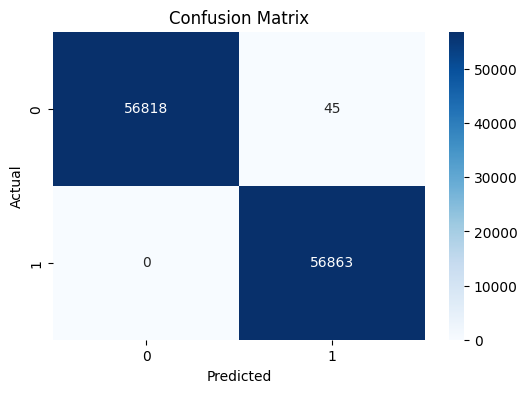

In [21]:
#8. Confusion Matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


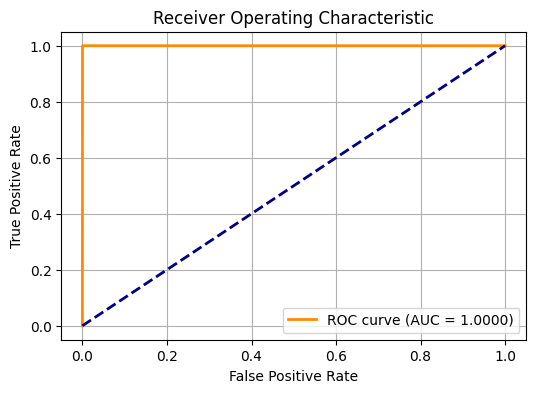

In [22]:
#9. ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


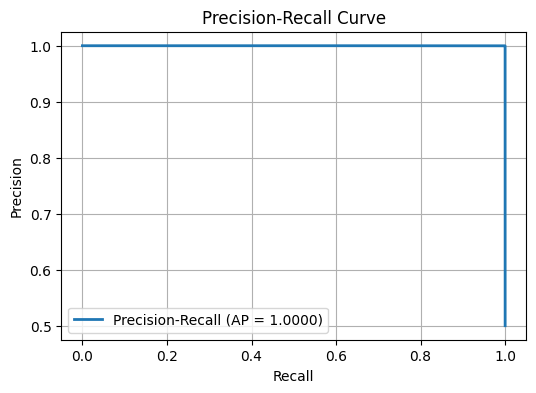

In [23]:
#10. Precison-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, lw=2, label=f'Precision-Recall (AP = {ap:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()



In [24]:
#11.  Save model to file

import joblib

joblib.dump(model, 'fraud_model.pkl')

['fraud_model.pkl']

In [26]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])

# Save the scaler object
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']